### **DATA IMPORT** 
First , I imported the data from Letterboxd and my own made Excel sheet which shows my academic workload with dates. Then I got time genres, year,language information of movies from TMDB database and made a concataned two datasets and made a big **allwatched** dataset.

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns

In [201]:
df_movies = pd.read_csv("diary.csv")
df_movies.head()

,Date,Name,Year,Letterboxd URI,Rating,Rewatch,Tags,Watched Date
0,2024-02-04,Past Lives,2023,https://boxd.it/5L4rrz,3.5,NaN,NaN,2024-02-03
1,2024-02-07,The Holdovers,2023,https://boxd.it/5MtQ2N,4.0,NaN,NaN,2024-02-06
2,2024-02-11,Dogville,2003,https://boxd.it/5Ob6dR,4.5,NaN,NaN,2024-02-11
3,2024-03-11,Anatomy of a Fall,2023,https://boxd.it/61m5hH,4.0,NaN,NaN,2024-03-10
4,2024-03-11,Poor Things,2023,https://boxd.it/61ylxb,3.0,NaN,NaN,2024-03-10


In [202]:
df_academic = pd.read_excel("academicworkload.xlsx")
print(df_academic.head())

         Date  Course     Type  Importancy
0  10-01-2026  DSA210     Exam        35.0
1  08-01-2026   IE305     Exam        40.0
2  07-01-2026  SPS303     Exam        40.0
3  06-01-2026   CS411  Project         4.5
4  06-01-2026   CS411     Exam        40.0


In [203]:
df_movies = df_movies.drop(columns=["Rewatch", "Tags", "Date"])

df_movies["Title"] = df_movies["Name"]
df_movies["MyRating"] = df_movies["Rating"]

df_movies["Watched Date"] = pd.to_datetime(df_movies["Watched Date"])
df_all = df_movies[df_movies["Watched Date"] >= "2025-06-01"].copy()

In [204]:
TMDB_KEY = "88856f7832f2d05db4970902b599d0ab"

def search_movie(title, year=None):
    title = requests.utils.quote(title)

    if pd.isna(year) or year == 0:
        url = f"https://api.themoviedb.org/3/search/movie?api_key={TMDB_KEY}&query={title}"
    else:
        url = f"https://api.themoviedb.org/3/search/movie?api_key={TMDB_KEY}&query={title}&year={int(year)}"

    data = requests.get(url).json()
    results = data.get("results", [])
    return results[0]["id"] if results else None

def get_movie(id):
    url = f"https://api.themoviedb.org/3/movie/{id}?api_key={TMDB_KEY}&append_to_response=credits"
    return requests.get(url).json()


In [205]:
rows = []

for idx, row in df_all.iterrows():
    title = row["Title"]
    year = row["Year"]

    movie_id = search_movie(title, year)

    if movie_id is None:
        print("Not found:", title)
        continue

    d = get_movie(movie_id)

    genres = ", ".join([g["name"] for g in d.get("genres", [])])
    runtime = d.get("runtime")
    vote = d.get("vote_average")
    lang = d.get("original_language")
    rel = d.get("release_date")
    pop = d.get("popularity")


    cast_list = [c["name"] for c in d.get("credits", {}).get("cast", [])[:5]]
    cast = ", ".join(cast_list)


    crew = d.get("credits", {}).get("crew", [])
    directors = ", ".join([c["name"] for c in crew if c.get("job") == "Director"])

    rows.append([
        title,
        row["MyRating"],
        row["Watched Date"],
        year,
        genres,
        runtime,
        vote,
        lang,
        rel,
        pop,
        cast,
        directors
    ])


In [206]:
df_watched= pd.DataFrame(rows, columns=[
    "Title", "MyRating", "MyWatchedDate",  "Year",
    "Genres", "Runtime", "TMDB_Rating", "Language",
    "ReleaseDate", "Popularity", "Cast", "Director"
])
df_watched = pd.DataFrame(df_watched)
df_watched.to_csv("allwatched.csv", index=False)
df_watched.head()


,Title,MyRating,MyWatchedDate,Year,Genres,Runtime,TMDB_Rating,Language,ReleaseDate,Popularity,Cast,Director
0,Challengers,4.0,2025-06-05,2024,"Drama, Romance",132,6.927,en,2024-04-18,9.5860,"Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...",Luca Guadagnino
1,The Ugly Stepsister,4.0,2025-06-05,2025,"Horror, Comedy, Fantasy, Drama",109,7.303,no,2025-03-07,20.6166,"Lea Myren, Ane Dahl Torp, Thea Sofie Loch Næss...",Emilie Blichfeldt
2,Triangle of Sadness,3.0,2025-06-05,2022,"Comedy, Drama",147,7.021,en,2022-09-18,4.6528,"Harris Dickinson, Charlbi Dean, Dolly de Leon,...",Ruben Östlund
3,Fat Girl,3.0,2025-06-05,2001,Drama,86,6.200,fr,2001-03-07,2.1718,"Anaïs Reboux, Roxane Mesquida, Libero De Rienz...",Catherine Breillat
4,Nymphomaniac: Vol. I,3.5,2025-06-06,2013,"Drama, Mystery",124,6.710,en,2013-12-25,10.6159,"Charlotte Gainsbourg, Stellan Skarsgård, Stacy...",Lars von Trier


### **EDA, VISUALIZATION and HYPOTHESIS TESTING**

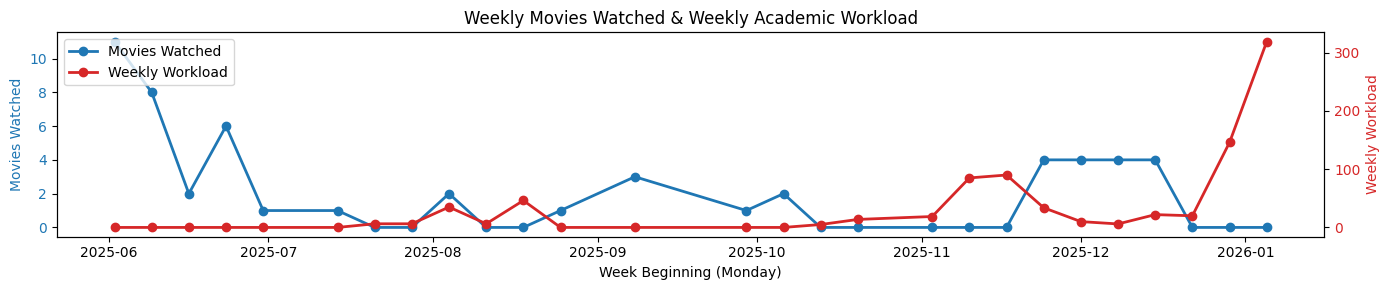

In [207]:
df_watched["MyWatchedDate"] = pd.to_datetime(df_watched["MyWatchedDate"])
df_academic["Date"] = pd.to_datetime(df_academic["Date"], dayfirst=True)


df_watched["WeekStart"] = df_watched["MyWatchedDate"] - pd.to_timedelta(df_watched["MyWatchedDate"].dt.weekday, unit='D')
df_academic["WeekStart"] = df_academic["Date"] - pd.to_timedelta(df_academic["Date"].dt.weekday, unit='D')


df_weekly_movies = (
    df_watched.groupby("WeekStart")["Title"]
    .count()
    .reset_index()
    .sort_values("WeekStart")
)
df_weekly_movies.columns = ["WeekStart", "MoviesWatched"]


df_weekly_workload = (
    df_academic.groupby("WeekStart")["Importancy"]
    .sum()
    .reset_index()
    .sort_values("WeekStart")
)
df_weekly_workload.columns = ["WeekStart", "WeeklyWorkload"]


df_weekly = pd.merge(df_weekly_movies, df_weekly_workload, on="WeekStart", how="outer").fillna(0)


plt.figure(figsize=(14,3))

ax1 = plt.gca()


ax1.plot(df_weekly["WeekStart"], df_weekly["MoviesWatched"],
         marker="o", color="tab:blue", linewidth=2, label="Movies Watched")
ax1.set_xlabel("Week Beginning (Monday)")
ax1.set_ylabel("Movies Watched", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")


ax2 = ax1.twinx()
ax2.plot(df_weekly["WeekStart"], df_weekly["WeeklyWorkload"],
         marker="o", color="tab:red", linewidth=2, label="Weekly Workload")
ax2.set_ylabel("Weekly Workload", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.xticks(rotation=45)
plt.title("Weekly Movies Watched & Weekly Academic Workload")
plt.tight_layout()
plt.show()


In [208]:
from scipy.stats import ttest_ind
median_w = df_weekly["WeeklyWorkload"].median()

high = df_weekly[df_weekly["WeeklyWorkload"] >= median_w]["MoviesWatched"]
low  = df_weekly[df_weekly["WeeklyWorkload"]  < median_w]["MoviesWatched"]

tstat, p = ttest_ind(high, low, equal_var=False)

print("High workload movie mean:", high.mean())
print("Low workload movie mean:", low.mean())
print("t-stat:", tstat)
print("p-value:", p)

High workload movie mean: 0.9333333333333333
Low workload movie mean: 3.3333333333333335
t-stat: -2.2578886715604476
p-value: 0.03899154533416262


In [209]:
df_weekly_workload = df_academic.groupby("WeekStart")["Importancy"].sum().reset_index()
df_weekly_workload.columns = ["WeekStart", "WeeklyWorkload"]

df_merge = df_watched.merge(df_weekly_workload, on="WeekStart", how="left")

median_w = df_merge["WeeklyWorkload"].median()
df_merge["WorkloadLevel"] = df_merge["WeeklyWorkload"].apply(
    lambda x: "High" if x >= median_w else "Low"
)

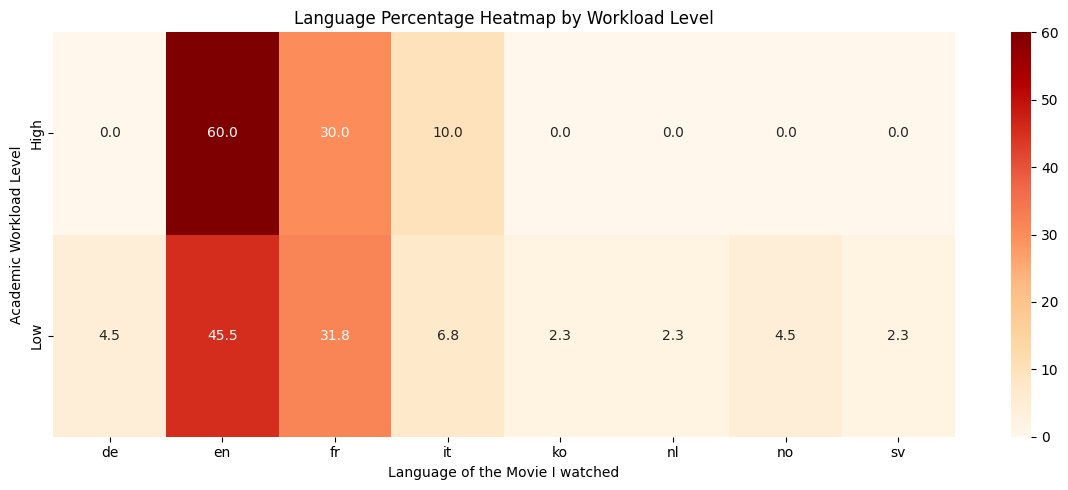

In [210]:

table_lang = pd.crosstab(df_merge["WorkloadLevel"], df_merge["Language"])

percentage_lang = table_lang.div(table_lang.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12,5))
sns.heatmap(percentage_lang, annot=True, fmt=".1f", cmap="OrRd")
plt.title("Language Percentage Heatmap by Workload Level")
plt.xlabel("Language of the Movie I watched")
plt.ylabel("Academic Workload Level")
plt.tight_layout()
plt.show()


In [211]:
from scipy.stats import chi2_contingency
print("Language Contingency Table:")
print(table_lang)

chi2, p, dof, expected = chi2_contingency(table_lang)

print("\nChi-square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)

print("\nExpected Frequencies:")
print(expected)

Language Contingency Table:
Language       de  en  fr  it  ko  nl  no  sv
WorkloadLevel                                
High            0   6   3   1   0   0   0   0
Low             2  20  14   3   1   1   2   1

Chi-square Statistic: 2.068870835047306
p-value: 0.9559302887623313
Degrees of Freedom: 7

Expected Frequencies:
[[ 0.37037037  4.81481481  3.14814815  0.74074074  0.18518519  0.18518519
   0.37037037  0.18518519]
 [ 1.62962963 21.18518519 13.85185185  3.25925926  0.81481481  0.81481481
   1.62962963  0.81481481]]


In [212]:
def clean_genre(g):
    g = str(g).lower()

    if "romance" in g:
        return "Romance"
    if "drama" in g:
        return "Drama"
    if "comedy" in g:
        return "Comedy"
    if "horror" in g:
        return "Horror"
    if "thriller" in g:
        return "Thriller"
    if "mystery" in g:
        return "Mystery"
    if "crime" in g:
        return "Crime"
    if "fantasy" in g:
        return "Fantasy"
    if "science fiction" in g or "sci-fi" in g:
        return "Science Fiction"
    if "action" in g:
        return "Action"
    if "animation" in g:
        return "Animation"
    if "adventure" in g:
        return "Adventure"

    return g.split(",")[0].strip().title()

df_merge["CleanGenre"] = df_merge["Genres"].apply(clean_genre)


In [213]:
table_genre = pd.crosstab(df_merge["WorkloadLevel"], df_merge["CleanGenre"])

chi2, p, dof, expected = chi2_contingency(table_genre)

print(table_genre)
print("Chi2:", chi2)
print("p-value:", p)


CleanGenre        Comedy  Crime  Drama  Horror  Romance  Thriller
WorkloadLevel                                                    
High           0       0      1      7       0        2         0
Low            1       2      0     16       3       21         1
Chi2: 9.626086956521737
p-value: 0.14130730554505316


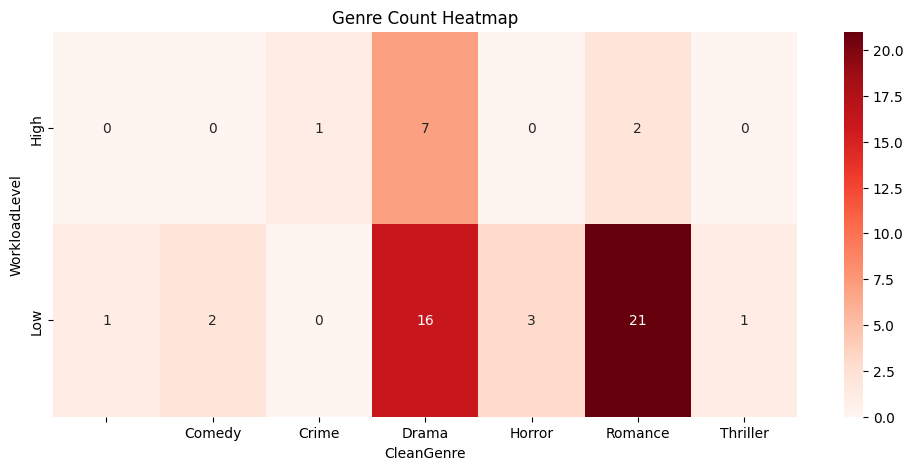

In [214]:
plt.figure(figsize=(12,5))
sns.heatmap(table_genre, annot=True, fmt="d", cmap="Reds")
plt.title("Genre Count Heatmap")
plt.show()


### **MACHINE LEARNING**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression


In [230]:
df_academic["Date"] = pd.to_datetime(df_academic["Date"], dayfirst=True
)
start_date = pd.to_datetime("22-09-2025", dayfirst=True)
df_academic_f = df_academic[df_academic["Date"] >= start_date].copy()
df_academic_f["week"] = ((df_academic_f["Date"] - start_date).dt.days // 7 + 1).astype(int)
df_weeklytotal = (df_academic_f.groupby("week")["Importancy"] .sum().reset_index())

max_week = df_academic_f["week"].max()
all_weeks = pd.DataFrame({"week": range(1, max_week + 1)})
df_weeklytotal = pd.merge(all_weeks,df_weeklytotal, on="week",how="left")
df_weeklytotal["Importancy"] = df_weeklytotal["Importancy"].fillna(0)

df_weeklytotal.head()

,week,Importancy
0,1,0.00
1,2,0.00
2,3,0.00
3,4,5.00
4,5,13.75


In [ ]:


X = df_weeklytotal[["week"]]
y = df_weeklytotal["Importancy"]

poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

model_imp = LinearRegression()
model_imp.fit(X_poly, y)
df_weeklytotal["fitted_importancy"] = model_imp.predict(X_poly)
df_weeklytotal["fitted_importancy"] = df_weeklytotal["fitted_importancy"].clip(lower=0)


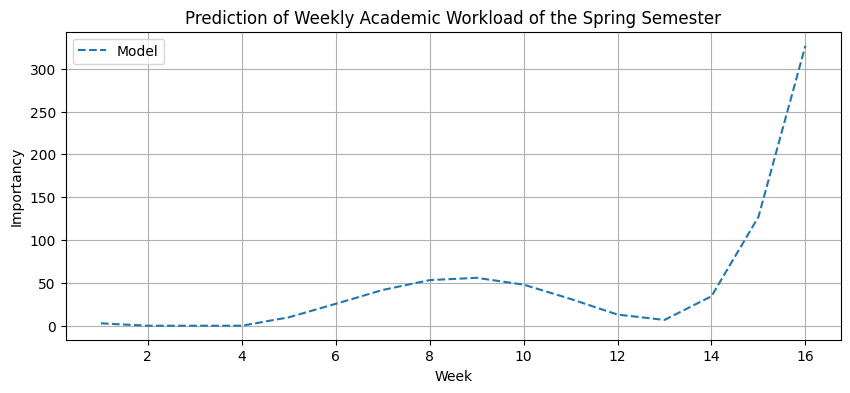

In [309]:
plt.figure(figsize=(10,4))

plt.plot(df_weeklytotal["week"], df_weeklytotal["fitted_importancy"],label="Model", linestyle="--")

plt.xlabel("Week")
plt.ylabel("Importancy")
plt.title("Prediction of Weekly Academic Workload of the Spring Semester")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_watched["MyWatchedDate"] = pd.to_datetime(
    df_watched["MyWatchedDate"],
    dayfirst=True
)
df_watched_f = df_watched[df_watched["MyWatchedDate"] >= start_date].copy()
df_watched_f["week"] = ((df_watched_f["MyWatchedDate"] - start_date).dt.days // 7 + 1).astype(int)
weekly_watch = ( df_watched_f.groupby("week").size().reset_index(name="weekly_watch_count"))
max_week = df_weeklytotal["week"].max()

all_weeks = pd.DataFrame({"week": range(1, max_week + 1)})
weekly_watch = pd.merge(all_weeks,weekly_watch,on="week",how="left")

weekly_watch["weekly_watch_count"] = (
    weekly_watch["weekly_watch_count"].fillna(0))
weekly_watch["watch_binary"] = (weekly_watch["weekly_watch_count"] > 0).astype(int)
df_model = pd.merge(df_weeklytotal[["week", "Importancy"]],weekly_watch[["week", "watch_binary"]],on="week")


In [ ]:
model_watch = LogisticRegression(
    class_weight="balanced"
)
model_watch.fit(df_model[["Importancy"]],df_model["watch_binary"])
df_weeklytotal["prob_watch"] = model_watch.predict_proba(df_weeklytotal[["fitted_importancy"]].rename(columns={"fitted_importancy": "Importancy"}))[:, 1]

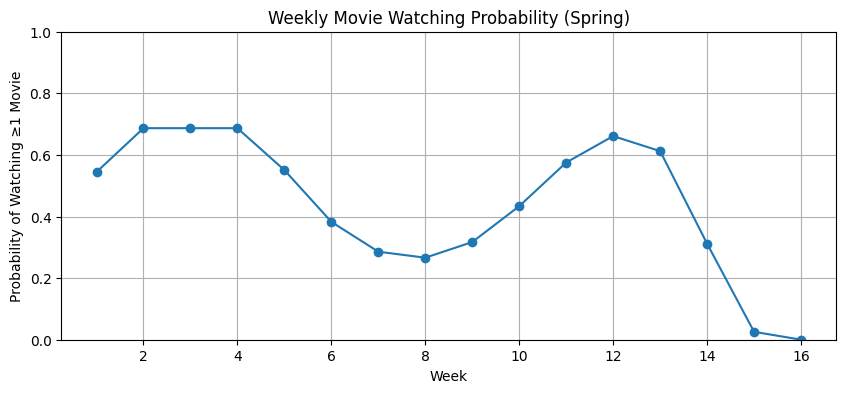

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(df_weeklytotal["week"],df_weeklytotal["prob_watch"],marker="o"
)

plt.xlabel("Week")
plt.ylabel("Probability of Watching a Movie")
plt.title("Weekly Movie Watching Probability in Spring Term ")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


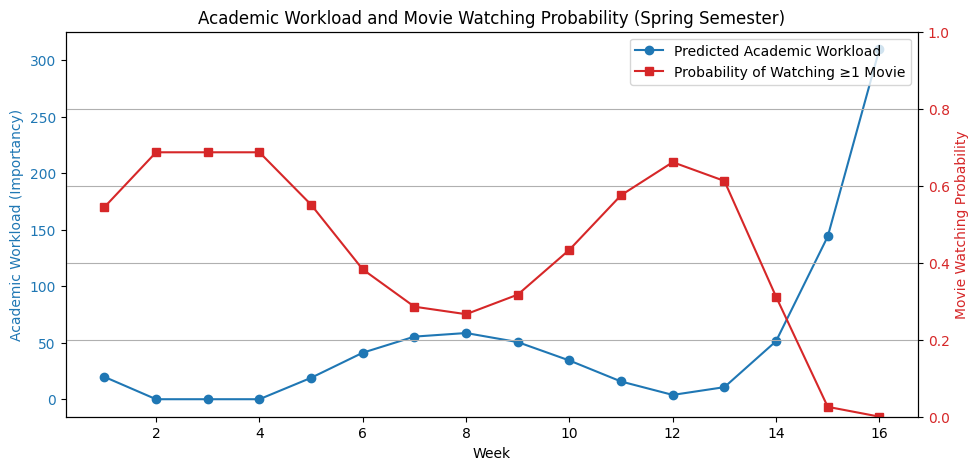

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(11,5))

ax1.plot(
    df_weeklytotal["week"],
    df_weeklytotal["fitted_importancy"],
    color="tab:blue",
    marker="o",
    label="Predicted Academic Workload"
)
ax1.set_xlabel("Week")
ax1.set_ylabel("Academic Workload (Importancy)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")


ax2 = ax1.twinx()
ax2.plot(
    df_weeklytotal["week"],
    df_weeklytotal["prob_watch"],
    color="tab:red",
    marker="s",
    label="Probability of Watching ≥1 Movie"
)
ax2.set_ylabel("Movie Watching Probability", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_ylim(0, 1)

plt.title("Academic Workload and Movie Watching Probability (Spring Semester)")


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
df_watched["MyWatchedDate"] = pd.to_datetime(df_watched["MyWatchedDate"], dayfirst=True)
df_watched_f = df_watched[df_watched["MyWatchedDate"] >= start_date].copy()

df_watched_f["week"] = ((df_watched_f["MyWatchedDate"] - start_date).dt.days // 7 + 1).astype(int)
df_genres = df_watched_f["Genres"].str.get_dummies(sep=", ")
df_genres["week"] = df_watched_f["week"]
weekly_genres = (df_genres.groupby("week").sum().reset_index())
weekly_genres.head()


,week,Action,Comedy,Crime,Drama,Horror,Mystery,Romance,Science Fiction,Thriller,Western
0,2,0,0,0,1,0,1,1,0,0,0
1,3,0,1,0,2,0,0,1,0,0,0
2,10,0,1,1,4,0,1,1,0,1,0
3,11,1,0,0,3,1,0,3,0,1,0
4,12,0,3,0,3,0,1,0,0,1,0


In [280]:
X = weekly_genres[["week"]]
y = weekly_genres.drop(columns=["week"])
knn = KNeighborsRegressor(n_neighbors=5 )
knn.fit(X, y)
last_week = weekly_genres["week"].max()
spring_weeks = pd.DataFrame({"week": range(last_week + 1, last_week + 15)})
spring_genre_pred = knn.predict(spring_weeks)
spring_genres = pd.DataFrame(spring_genre_pred,columns=y.columns)
total_genres_spring = (spring_genres.sum().sort_values(ascending=False))

total_genres_spring

Drama              42.0
Comedy             14.0
Romance            14.0
Crime               8.4
Thriller            8.4
Mystery             5.6
Action              2.8
Horror              2.8
Science Fiction     2.8
Western             2.8
dtype: float64

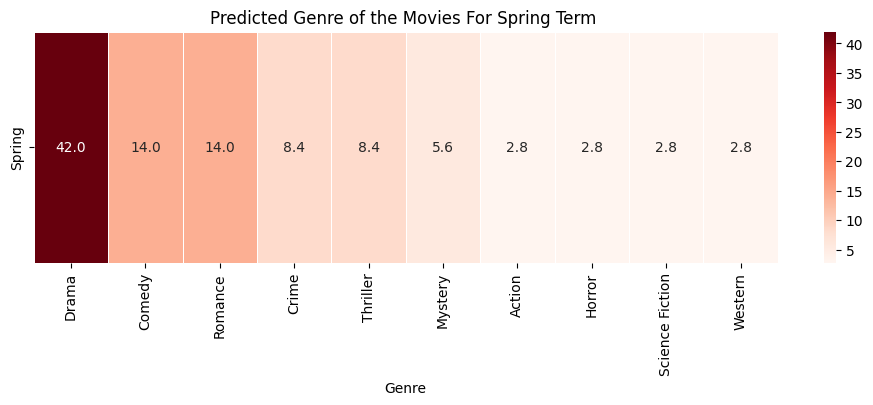

In [ ]:
heatmap_genre = total_genres_spring.to_frame().T
heatmap_genre.index = ["Spring Term "]
plt.figure(figsize=(12,3)) 
sns.heatmap(heatmap_genre,annot=True,fmt=".1f",cmap="Reds",linewidths=0.5)
plt.title("Predicted Genre of the Movies For Spring Term ")
plt.xlabel("Genre")
plt.ylabel("")
plt.show()


In [281]:
weekly_languages = ( df_watched_f.groupby(["week", "Language"]).size() .unstack(fill_value=0).reset_index())

X = weekly_languages[["week"]]
y = weekly_languages.drop(columns=["week"])

knn_lang = KNeighborsRegressor(n_neighbors=5)

knn_lang.fit(X, y)
last_week = weekly_languages["week"].max()

spring_weeks = pd.DataFrame({"week": range(last_week + 1, last_week + 15)})

spring_lang_pred = knn_lang.predict(spring_weeks)

spring_languages = pd.DataFrame( spring_lang_pred,columns=y.columns)
total_languages_spring = (spring_languages.sum() .sort_values(ascending=False))

total_languages_spring


Language
en    30.8
fr    14.0
it     2.8
no     2.8
dtype: float64

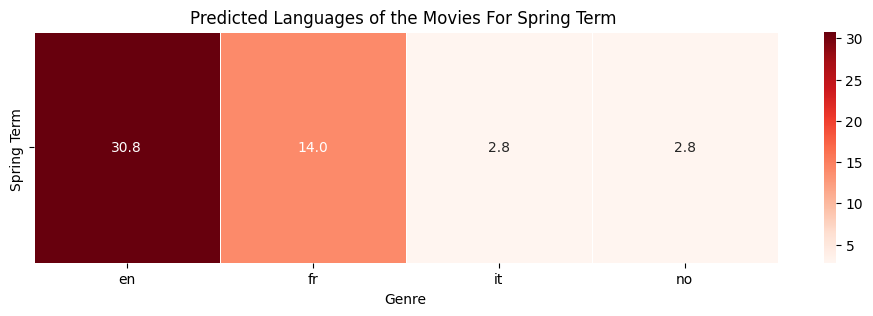

In [282]:
heatmap_genre = total_languages_spring.to_frame().T
heatmap_genre.index = ["Spring Term "]
plt.figure(figsize=(12,3)) 
sns.heatmap(heatmap_genre, annot=True,fmt=".1f", cmap="Reds",linewidths=0.5)
plt.title("Predicted Languages of the Movies For Spring Term ")
plt.xlabel("Genre")
plt.ylabel("")
plt.show()
